# Biofilm Formation Assay

## Introduction
This script was created for the analysis of biofilm production in microbial model communities. The microbial model community that is used in the example is called PPK and is conformed by three species: *Pseudomonas aeruginosa* (Pao1), *Pseudomonas protegens* (Pf5), and *Klebsiella pneumoniae* (Kp1). The assay consists in culturing the three species separately, in co-cultures (two by two) and finally all three together (Triculture or TC), the setup consist in 96 well plates with at least 8 technical replicates per level (each species alone and all possible combination of the different species).
The cultures are harvested for biofilm quantification once per day, for 5 days or time points. Biofilm production was quantified by the crystal-violet methodology, the data obtained are absorbance values for each of the 96 wells of the plate, one plate per time-point.

### The current script
The current script was elaborated for data processing and data analysis. Data is provided in a *.csv* file, each row being a treatment level and each column is a technical repetition (from 1 to 8), the last column indicates the time-point in which data was collected (Day).

### Conda environment 

This script should be run with the conda environment `environment_jorge.yaml` provided in this github repository, the environment name is : `python_test`.
So you can run: `conda create --name python_test --file environment_jorge.yaml` on the terminal and then activate `python_test`.

Finally, use that environment as a kernel for running this notebook.
Enjoy.

## Import the packages and the data:

In [27]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, f_oneway, kruskal
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

## Load the data

In [28]:
#relative path
relative_path = 'ppk_biofilm.csv'
# Load the csv data 
df1 = pd.read_csv(relative_path, delimiter=';')
print(df1.head(20))

# About the data: estimation of biofilm formation
# Absorvance at OD590 for members of the PPK community, quantified at 5 different time points (day 1 to day 5) 
# for the single cultures: Pao1, KP1, PF5, all the 2 by 2 combinatios, and the triple culture.


     Culture       1       2       3       4       5       6       7       8  \
0       Pao1  0,4552  0,2997  0,2464  0,2532  0,2509  0,2672  0,2678  0,4056   
1        KP1   0,082  0,0947  0,0934  0,0959  0,0892  0,0873  0,1005  0,1267   
2        PF5  0,2789  0,2489  0,1765  0,2458   0,254  0,1434  0,2572  0,2718   
3   Pao1_KP1  1,0841  0,3991  0,4593  0,3691  0,3719  0,3884  0,3444  0,4856   
4   Pao1_KP1   0,686  0,9119  0,4577  0,3745   0,458  0,9149  0,5206   0,595   
5   Pao1_PF5  0,6131  0,4359  0,3183  0,2856  0,3063  0,3315  0,3094  0,3697   
6   Pao1_PF5  0,4954  0,4228  0,2993  0,2508  0,2574   0,255  0,2184  0,2926   
7    KP1_PF5  0,3633  0,3768  0,1863  0,1374  0,1486  0,2324  0,1942  0,1865   
8         TC  0,9136  0,5436  0,3748  0,3294  0,3289  0,2858  0,2934  0,4373   
9         TC  0,7967  0,8567  0,3405  0,2955  0,3106  0,3127  0,3347  0,3396   
10        TC  1,0215  0,6011  0,3803  0,3569  0,3648  0,3586  0,4024   0,427   
11   Control  0,1377  0,1516  0,1631  0,

In [29]:
#change the decimal separator from ',' to '.' so the numbers with decimals will be recognized as such

columns_to_convert = ['1', '2', '3', '4', '5', '6', '7', '8']

for col in columns_to_convert:
    df1[col] = df1[col].str.replace(',', '.').astype(float)


In [30]:
print(df1.head(10))

    Culture       1       2       3       4       5       6       7       8  \
0      Pao1  0.4552  0.2997  0.2464  0.2532  0.2509  0.2672  0.2678  0.4056   
1       KP1  0.0820  0.0947  0.0934  0.0959  0.0892  0.0873  0.1005  0.1267   
2       PF5  0.2789  0.2489  0.1765  0.2458  0.2540  0.1434  0.2572  0.2718   
3  Pao1_KP1  1.0841  0.3991  0.4593  0.3691  0.3719  0.3884  0.3444  0.4856   
4  Pao1_KP1  0.6860  0.9119  0.4577  0.3745  0.4580  0.9149  0.5206  0.5950   
5  Pao1_PF5  0.6131  0.4359  0.3183  0.2856  0.3063  0.3315  0.3094  0.3697   
6  Pao1_PF5  0.4954  0.4228  0.2993  0.2508  0.2574  0.2550  0.2184  0.2926   
7   KP1_PF5  0.3633  0.3768  0.1863  0.1374  0.1486  0.2324  0.1942  0.1865   
8        TC  0.9136  0.5436  0.3748  0.3294  0.3289  0.2858  0.2934  0.4373   
9        TC  0.7967  0.8567  0.3405  0.2955  0.3106  0.3127  0.3347  0.3396   

   Day  
0    1  
1    1  
2    1  
3    1  
4    1  
5    1  
6    1  
7    1  
8    1  
9    1  


In [31]:
# Calculate the mean and standar deviation for each culture treatmend and day
means = df1.groupby(['Culture', 'Day']).mean()
stds = df1.groupby(['Culture', 'Day']).std()

In [32]:
# Melting the data: Organize the data in a 'unidimensional way', that is to say for each row just one absorvance value
melted_df1 = pd.melt(df1, id_vars=['Culture', 'Day'], var_name='Replicate', value_name='Value')
melted_df1

,Culture,Day,Replicate,Value
0,Pao1,1,1,0.4552
1,KP1,1,1,0.0820
2,PF5,1,1,0.2789
3,Pao1_KP1,1,1,1.0841
4,Pao1_KP1,1,1,0.6860
...,...,...,...,...
475,KP1_PF5,5,8,0.1411
476,TC,5,8,0.2170
477,TC,5,8,0.2787
478,TC,5,8,0.3616


## Data analysis

### Dinamics of biofilm production

A line-plot will be generated to show the temporal dinamics of biofilm production for all treatments.

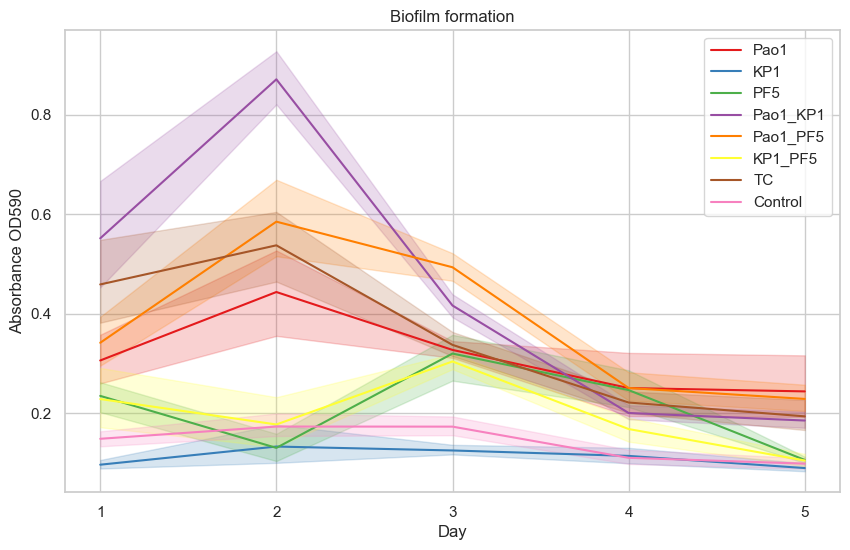

In [33]:
# Plot the biofilm formation overtime for each culture treatment

## Constructing the figuere: 

plt.figure(figsize=(10, 6))
sns.set_palette("Set1") #sellect the colour palette

treatments = melted_df1['Culture'].unique()

### Plot absorvance values for each day (x axes) but separated by treatment (Culture)
for treatment in treatments:
    data = melted_df1[melted_df1['Culture'] == treatment]
    sns.lineplot(data=data, x='Day', y='Value', label=treatment)

plt.xlabel('Day')
plt.ylabel('Absorbance OD590')
plt.title('Biofilm formation')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()


### Statistical analysis

The normal distribution of the data is evaluated using a Shapiro test, if data has a normal distribution then a one-way anova is performed, else, a Kruskal-Wallis test is performed. If the analysis finds significat differences in the treatmens per day, then a pos hoc analysis is performed, Tukey-test or Dunn-test for normaly distributed data and non-normaly distributed data respectively.

In [34]:
# store the data in a dictionary to use it later in the statistical analysis

dunn_results = {}  # To store results of the Dunn test
tukey_results = {}  # To store results of the Tukey test

# Separate the data for each timepoint (Day)
timepoints = melted_df1['Day'].unique()

for day in timepoints:
    print(f"Timepoint (Day) {day}:")
    
    # Filter the data for the current timepoint (Day) because we are doing the comparations of results for each day separately
    day_data = melted_df1[melted_df1['Day'] == day]
    
    # Check for normality of the data
    shapiro_test_statistic, shapiro_p_value = shapiro(day_data['Value'])
    
    if shapiro_p_value < 0.05:
        print("The data is not normally distributed, we can perform Kruskal-Wallis.")
        
        # Perform Kruskal-Wallis test
        groups = [group['Value'] for name, group in day_data.groupby('Culture')]
        h_statistic, p_value = kruskal(*groups)
        
        print(f"H-statistic: {h_statistic}")
        print(f"P-value: {p_value}")
        
        if p_value < 0.05:
            print("Statistically significant differences exist among treatments (Kruskal-Wallis test).")
            dunn_result = posthoc_dunn(day_data, val_col='Value', group_col='Culture')
            dunn_results[day] = dunn_result  # Store the Dunn result in the dictionary
            print(dunn_result)
            
        else:
            print("No statistically significant differences among treatments (Kruskal-Wallis test).")
    else:
        print("The data appears to be normally distributed, we can perform ANOVA.")
        
        # Perform one-way ANOVA
        groups = [group['Value'] for name, group in day_data.groupby('Culture')]
        f_statistic, p_value = f_oneway(*groups)
        
        print(f"F-statistic: {f_statistic}")
        print(f"P-value: {p_value}")
        
        if p_value < 0.05:
            print("Statistically significant differences exist among treatments (ANOVA test).")
            mc = MultiComparison(day_data['Value'], day_data['Culture'])
            result = mc.tukeyhsd()
            tukey_results[day] = result  # Store the Tukey result in the dictionary
            print(result)
                
        else:
            print("No statistically significant differences among treatments ANOVA test).")
    
    print("\n")


Timepoint (Day) 1:
The data is not normally distributed, we can perform Kruskal-Wallis.
H-statistic: 67.59613939003441
P-value: 4.515177141412259e-12
Statistically significant differences exist among treatments (Kruskal-Wallis test).
               Control           KP1   KP1_PF5       PF5      Pao1  \
Control   1.000000e+00  4.952009e-01  0.229139  0.293712  0.027896   
KP1       4.952009e-01  1.000000e+00  0.059478  0.083260  0.003967   
KP1_PF5   2.291389e-01  5.947844e-02  1.000000  0.878740  0.319169   
PF5       2.937118e-01  8.326038e-02  0.878740  1.000000  0.250666   
Pao1      2.789593e-02  3.966583e-03  0.319169  0.250666  1.000000   
Pao1_KP1  9.457042e-08  9.100622e-10  0.000079  0.000037  0.005143   
Pao1_PF5  1.660188e-03  8.399869e-05  0.079003  0.053277  0.544365   
TC        5.260485e-06  7.066511e-08  0.002061  0.001083  0.062713   

              Pao1_KP1  Pao1_PF5            TC  
Control   9.457042e-08  0.001660  5.260485e-06  
KP1       9.100622e-10  0.000084  7.0

### Pos hoc heatmaps for statisticallly significant differences 

Plot some heatmaps to easily visualize the results of the multiple comparations tests, if the distribution was not normal and the analysis was a Kruskal-Wallis test with a Dunn test as pos hoc, use this code chunk, otherwise use the next one.

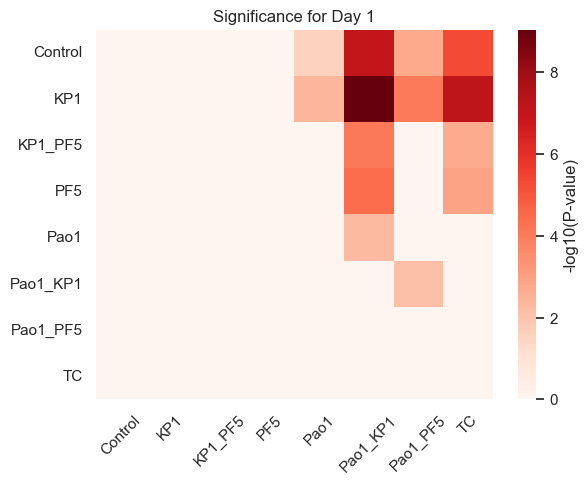

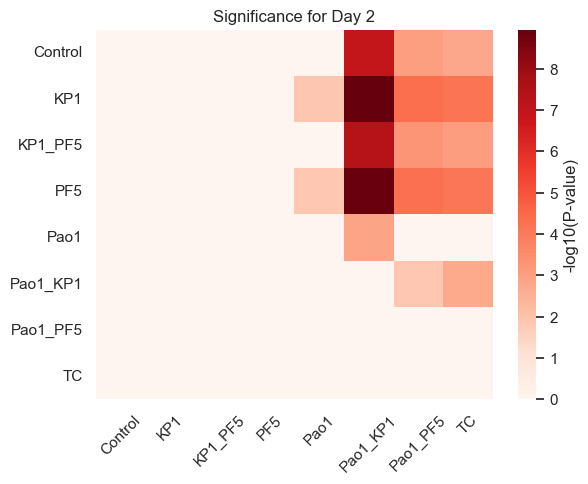

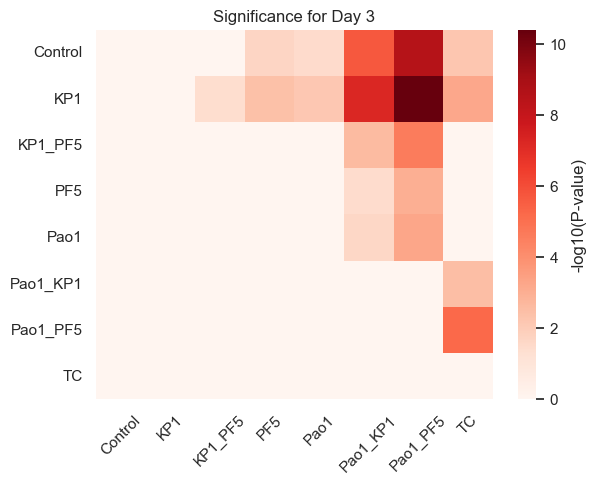

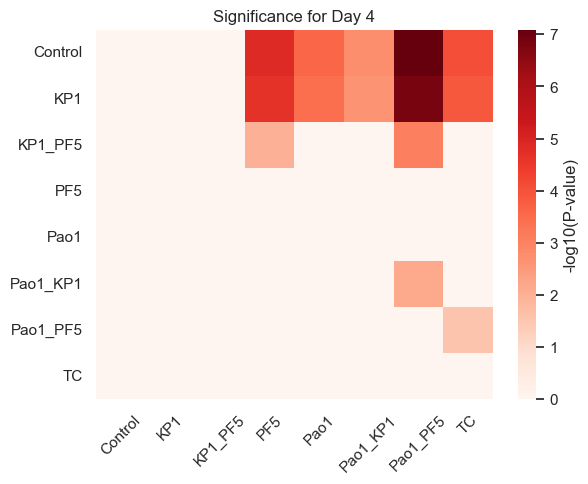

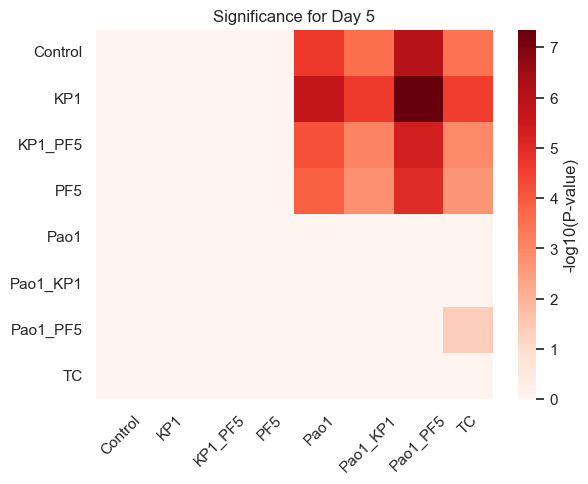

In [35]:
# Generate a heatmaps for each day's Dunn test: dunn_results
def generate_heatmaps(dunn_results):
    for day, result in dunn_results.items():
        comparisons = result.columns 
        n = len(comparisons)
        matrix = np.zeros((n, n), dtype=float)

        for i in range(n):
            for j in range(i + 1, n):
                comp_i, comp_j = comparisons[i], comparisons[j]
                p_value = result.at[comp_i, comp_j]
                if p_value < 0.05:  # Statistically significant
                    matrix[i, j] = -np.log10(p_value)  
                else:
                    matrix[i, j] = 0  

        # Create a mask to hide the lower triangle, that way the data is not duplicated
        mask = np.tril(np.ones_like(matrix))
        matrix = np.ma.array(matrix, mask=mask)

        # Create a custom colormap with a gradient from white to red
        cmap = sns.color_palette("Reds", as_cmap=True)

        # Create a heatmap w
        sns.heatmap(matrix, cmap=cmap, cbar_kws={'label': '-log10(P-value)'})

        # Customize the plot
        plt.title(f"Significance for Day {day}")
        plt.xticks(np.arange(n) + 0.5, comparisons, rotation=45)
        plt.yticks(np.arange(n) + 0.5, comparisons, rotation=0)

        # Show the plot
        plt.show()

# Generate heatmaps for Dunn test results
generate_heatmaps(dunn_results)


### Pos hoc heatmaps for statisticallly significant differences 

Plot some heatmaps to easily visualize the results of the multiple comparations tests, if the distribution was normal and the analysis was an ANOVA test with a Tukey test as pos hoc, use this code chunk, otherwise use the previous one.

In [38]:
# Generate a heatmaps for each day's Tukey test: tukey_results
def generate_heatmaps(tukey_results):
    for day, result in tukey_results.items():
        comparisons = result.columns 
        n = len(comparisons)
        matrix = np.zeros((n, n), dtype=float)

        for i in range(n):
            for j in range(i + 1, n):
                comp_i, comp_j = comparisons[i], comparisons[j]
                p_value = result.at[comp_i, comp_j]
                if p_value < 0.05:  # Statistically significant
                    matrix[i, j] = -np.log10(p_value)  
                else:
                    matrix[i, j] = 0  

        # Create a mask to hide the lower triangle, that way the data is not duplicated
        mask = np.tril(np.ones_like(matrix))
        matrix = np.ma.array(matrix, mask=mask)

        # Create a custom colormap with a gradient from white to red
        cmap = sns.color_palette("Reds", as_cmap=True)

        # Create a heatmap w
        sns.heatmap(matrix, cmap=cmap, cbar_kws={'label': '-log10(P-value)'})

        # Customize the plot
        plt.title(f"Significance for Day {day}")
        plt.xticks(np.arange(n) + 0.5, comparisons, rotation=45)
        plt.yticks(np.arange(n) + 0.5, comparisons, rotation=0)

        # Show the plot
        plt.show()

# Generate heatmaps for the test results
generate_heatmaps(tukey_results)


### Box-plots to explore the results per day

Now the script will generate 5 differen box-plots, one per day, to facilitate the visualization of the results in a time-point of interest and facilitate the exploration of the results.

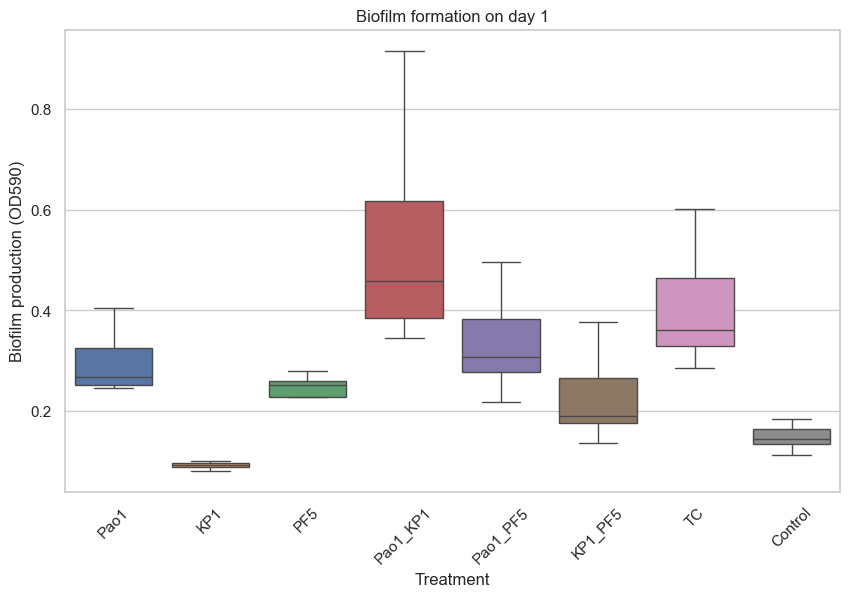

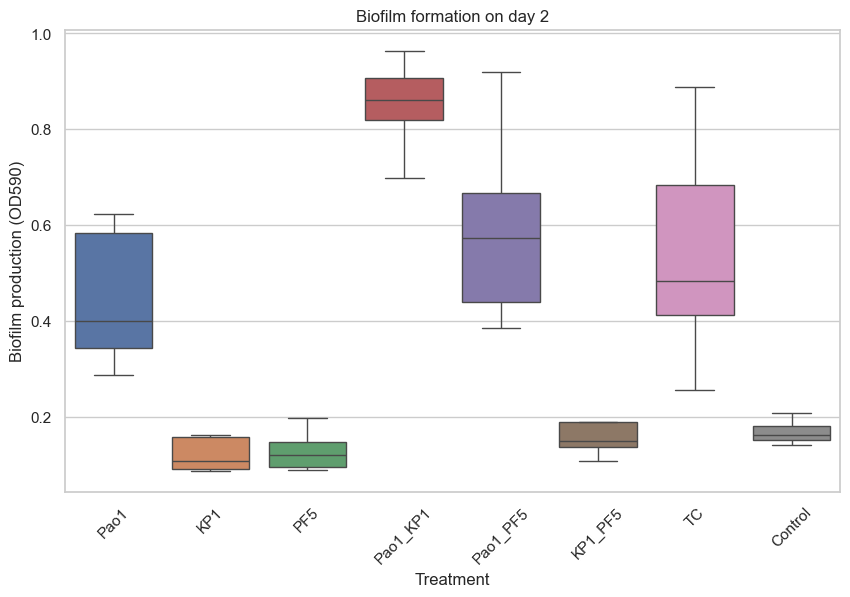

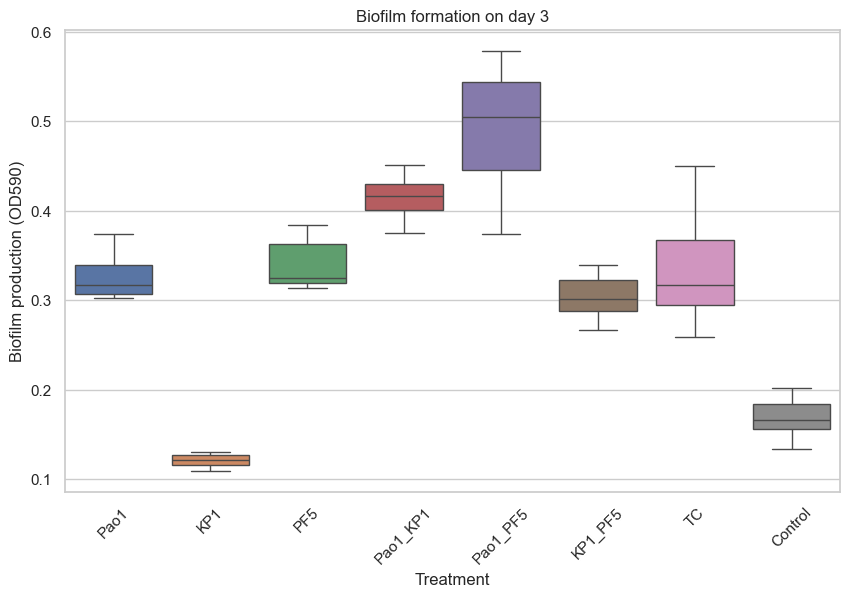

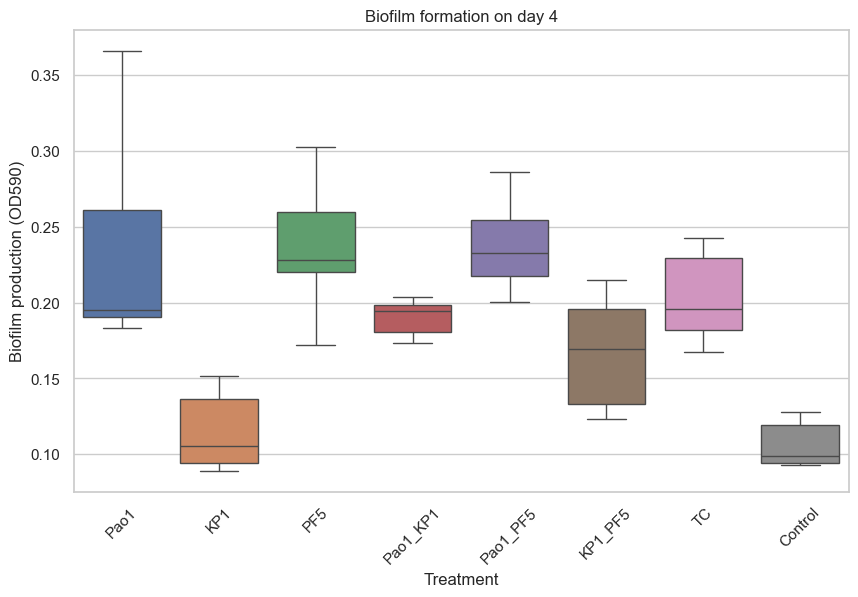

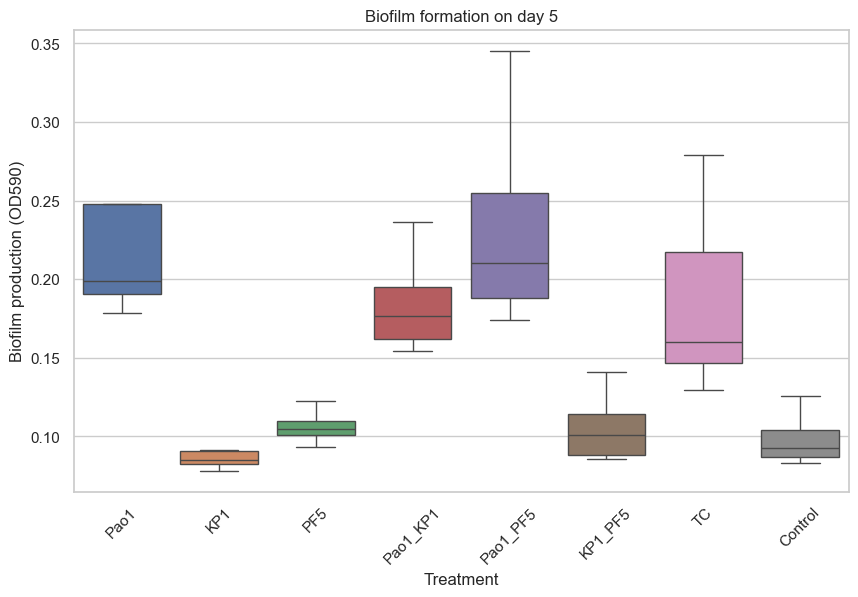

In [36]:
%matplotlib inline

# Set the style for the plots
sns.set(style="whitegrid")

# Create a list of unique days
unique_days = melted_df1['Day'].unique()

# Create a box plot for each day
for desired_day in unique_days:
    # Filter the data for the desired day
    day_data = melted_df1[melted_df1['Day'] == desired_day]

    # Create a box plot of biofilm production values for each treatment on each day
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Culture', y='Value', data=day_data, showfliers=False, hue='Culture')
    plt.xlabel('Treatment')
    plt.ylabel('Biofilm production (OD590)')
    plt.title(f'Biofilm formation on day {desired_day}')
    plt.xticks(rotation=45)  # Rotate x-axis labels 45° for better visibility
    plt.show()
